# Applied Data Science Specialisation Capstone

##### This notebook is for the Applied Data Science Capstone course project . ( Part of the IBM Data Science Professional Certification )

## The Battle of Neighbourhoods - Neighbourhoods Segmentation and Clustering

In this project, given a city like the City of Toronto, we will segment it into different neighbourhoods using the geographical coordinates of the centre of each neighbourhood. Then, using a combination of location data and machine learning, we will group the neighbourhoods into clusters.

#### Import all the libraries required.

In [1]:
# library for data manipulations and analyses
import pandas as pd

# customize row/clumn display aspects
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# library for similar manipulation making use of vectors
import numpy as np

# library for HTTP reuests
import requests

# library for parsing HTML data
from bs4 import BeautifulSoup

# library for converting address into latitude and longitude values
from geopy.geocoders import Nominatim

# library for map rendering
# !pip install folium
import folium

# cdist for determining optimal K in K Means clustering
from scipy.spatial.distance import cdist

# sklearn's KMeans for clustering
from sklearn.cluster import KMeans

# library for colors on maps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
# test cell (ignore this cell)
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


##### Note: For some reason Folium maps are not visible on the GitHub repositories. Check out the repository files for seperate map images files.

## Submission: Part 1

#### Get Wikipedia page's HTML into the notebook using GET requests.

In [3]:
# define webpage for scraping
webpage_URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# send GET requests and examine results
page = requests.get(webpage_URL)

#### Wrangle required information into a pandas dataframe using Beautiful Soup.

In [4]:
# define Beutiful Soup object
soup = BeautifulSoup(page.content, 'html.parser')

# extract table HTML from page content
table = soup.find('table')

# 'table_rows' stores data for all postal codes in list of lists format
table_rows = []

# extract and clean text in td tags for postal code, borough and neighbourhood information
for row in table.findAll('td'):
    # 'case' to store processed row in each iteration
    case = {}
    
    # do not process 'Not assigned' cells on Wikipedia page
    if row.span.text == 'Not assigned':
        pass
    else:
        # first 3 characters from text under p tag go for postal code
        case['PostalCode'] = row.p.text[:3]
        
        # first '(' split element from text under span tag go for borough
        case['Borough'] = (row.span.text).split('(')[0]
        
        # second split + more cleaning go for neighbourhood
        case['Neighbourhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        
        # append processed row
        table_rows.append(case)

# create a daatframe for to list of lists containing neighbourhood data
toronto_data = pd.DataFrame(table_rows)

# rename borough names for uniformity
toronto_data['Borough'] = toronto_data['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                                                       'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                                                       'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                                                       'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
# check shape of final dataframe
toronto_data.shape

(103, 3)

## Submission: Part 2

#### Add latitude and longitude coordinates information this neighbourhood data using the 'GeoSpatial Dataset'.

In [6]:
# NOTE: The data has been uploaded to the GitHub repository and the raw version of it being used directly form there.

# data file URL form GitHub
data_URL = 'https://raw.githubusercontent.com/guptasaumya/coursera-capstone/master/Geospatial_Coordinates.csv'

# load data into pandas dataframe
geocoordinate_data = pd.read_csv(data_URL)

#### Merge data into geocoordinates data to neighbourhood data.

In [7]:
# merge and drop duplicate column
toronto_data = toronto_data.merge(geocoordinate_data, left_on='PostalCode', right_on='Postal Code').drop(['Postal Code'], axis=1)

toronto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


## Submission: Part 3

In [8]:
toronto_data.Borough.unique()

array(['North York', 'Downtown Toronto', "Queen's Park", 'Etobicoke',
       'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto',
       'East York/East Toronto', 'Central Toronto', 'Mississauga',
       'Downtown Toronto Stn A', 'Etobicoke Northwest',
       'East Toronto Business'], dtype=object)

In [9]:
# use geopy library to get latitude and longitude values of city of Toronto
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(toronto_data['Latitude'],
                                            toronto_data['Longitude'],
                                            toronto_data['Borough'],
                                            toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

map_toronto

##### Note: For this map result check out map_result_1.png in the repository.

#### Define Foursquare API usage credentials and version.

In [10]:
# The code was removed by Watson Studio for sharing.

In [11]:
# define function gets nearby venues for each neighbourhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    # 'venues_list' stores venues data for all postal codes in list of lists format
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        print(name)

        # create API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # send GET requests and examine results
        response = requests.get(url).json()["response"]['groups'][0]['items']

        # append only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in response])

    # create a dataframe from list of lists containing neighbourhood data
    nearby_venues = pd.DataFrame([item for venue_list in venues_list
                                  for item in venue_list])
    
    # rename columns for uniform column name format
    nearby_venues.columns = ['Neighbourhood',
                             'NeighbourhoodLatitude',
                             'NeighbourhoodLongitude',
                             'Venue',
                             'VenueLatitude',
                             'VenueLongitude',
                             'VenueCategory']

    # return resulting dataframe
    return(nearby_venues)

In [12]:
# define function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

#### In this solution, I am working with all 103 postal codes and not just the ones with the 'Toronto' substring.

In [13]:
# call function get nearby venues for each neighbourhood
toronto_venues = getNearbyVenues(toronto_data['Neighbourhood'],
                                 toronto_data['Latitude'],
                                 toronto_data['Longitude'],
                                 # finding neraby venues within 500 meter radius
                                 500)

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

##### Note:  In the above code, only 99 out of 103 postal codes / neighbourhoods had venues in the radius of 500. We do not consider and include the rest 4 neighbourhoods for our analysis and move forward.

#### Pre-processs the data before clustering analysis.

In [14]:
# one-hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['VenueCategory']],
                                prefix="",
                                prefix_sep="")

# add 'Neighbourhood' column to this dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move 'Neighbourhood' column to first position
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

# group rows by neighborhood taking mean of frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()

toronto_grouped.head()

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0

#### Get top 10 most common venue categories for each postal code / neighbouhood for future cluster examinations.

In [15]:
# we will look into top 10 most common venue categories
num_top_venues = 10

# define positions indicator suffixes
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create new dataframe structure
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)

# add neighbourhood data
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

# add top 10 most common venue categories for these neighbourhoods
for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :],
                                                                          num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
1,"Alderwood, Long Branch",Pizza Place,Gym,Pub,Sandwich Place,Dance Studio,Coffee Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Fried Chicken Joint,Sandwich Place,Diner,Restaurant,Deli / Bodega,Middle Eastern Restaurant,Mobile Phone Shop,Supermarket
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Sushi Restaurant,Hobby Shop,Restaurant,Pub,Café,Butcher,Juice Bar


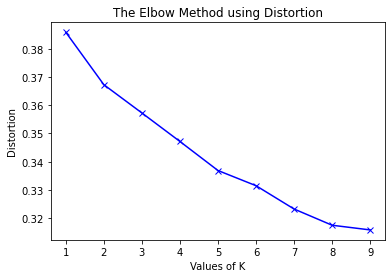

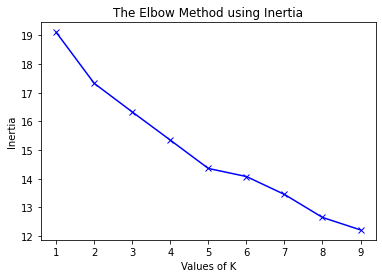

In [18]:
# find optimal k checking both distortions and inertias with reduced data

# define clustering data (data on basis of which clustering is performed)
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# we will check elbow plots for distortions and inertia
distortions = []
inertias = []

# check for K ranging from 1 to 10
K = range(1, 10)

for k in K:
    # define KMeans object
    kmeans_model = KMeans(n_clusters = k, random_state=0)
    
    # fit clustering data
    kmeans_model.fit(toronto_grouped_clustering)
 
    # calculate distortion measure
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeans_model.cluster_centers_,
                                        'euclidean'), axis = 1)) / toronto_grouped_clustering.shape[0])
    # calculate inertia measure
    inertias.append(kmeans_model.inertia_)
    
# plot distortions elbow plot (with different Ks)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# plot inertias elbow plot (with different Ks)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

#### 5 number of clusters seems to be the elbow and hence a good K-value.

In [19]:
# fit kmeans model with 5 clusters - optimal value of k
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in dataframe
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0], dtype=int32)

In [20]:
# combine clustering information with other data for cluster examination
neighbourhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'),
                                     on='Neighbourhood', how='right')

toronto_merged.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,Fast Food Restaurant,Park,Food & Drink Shop,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dim Sum Restaurant,Dumpling Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Portuguese Restaurant,French Restaurant,Pizza Place,Coffee Shop,Hockey Arena,Intersection,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Restaurant,Café,French Restaurant,Beer Store
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,Clothing Store,Accessories Store,Gift Shop,Furniture / Home Store,Athletics & Sports,Coffee Shop,Carpet Store,Boutique,Vietnamese Restaurant,Diner
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Café,Diner,College Cafeteria,Beer Bar,Spa,Smoothie Shop,Sandwich Place,Burrito Place


In [ ]:
# look at number of neighboods per cluster
toronto_merged.ClusterLabels.value_counts()

#### Display clustered Toronto city neighbourhoods on map.

In [21]:
# create map of Toronto using latitude and longitude values
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'],
                                  toronto_merged['Longitude'],
                                  toronto_merged['Neighbourhood'],
                                  toronto_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster),
                         parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

    # view clusters at the end
map_clusters

##### Note: For this map result check out map_result_2.png in the repository.